In [76]:
from bankingSystem import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings 
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
pylab.rcParams['figure.figsize'] = (10, 10)
pylab.rcParams['font.size'] = 20

# start from here
bankFile = "balanceSheetAnalysis/banksData_2022.csv"
params = {"banksFile" : bankFile, # csv file used to initialize the bank agents
                 "leverageRatio": 20, # leverage ratio upper bound for all banks
                 "depositReserve": 0.2, # capital reserve as a ratio of deposit
                 "num_borrowing": 10, # number of borrowing request per bank per step
                 "sizeOfBorrowing": 1.0, # size of borrowing as a ratio of equity capital
                 "concentrationParameter": np.load("concentrationParams.npy"), # concentration parameter for the dirichlet distribution
                 "num_banks": 100, # number of banks in the system 
                 "alpha" : 0.5,    # portfolio recovery rate          
                 "beta" : 0.9,     # interbank loan recovery rate
                 "fedRate" : 0.04, # interest rate on borrowing   
                 "portfolioReturnRate" : 0.10, 
                 "returnVolatiliy" : 0.18,
                 "returnCorrelation" : 0.8,
                 "liquidityShockNum" : 0,  # number of liquidity shocks per step (not correlated shocks)
                 "shockSize" : 20,       # size of the shock
                 "shockDuration":[300, 300]} # time of the shock, [-1,-1] sugguests no shock

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


### model without the exogeous shock

In [77]:
numberOfRun = 48
simulationSteps = 500
rCollection = multiRun(numberOfRun, params)

48


In [78]:
for i,r in enumerate(rCollection):
    if i == 0:
        agentData, modelData = r
        IndegreeCollection = np.array([(modelData["Liability Matrix"][j]>0).sum(axis=0) for j in range(simulationSteps)])
        OutdegreeCollection = np.array([(modelData["Liability Matrix"][j]>0).sum(axis=1) for j in range(simulationSteps)])
    else:
        a, m = r
        agentData += a
        modelData += m
        IndegreeCollection += np.array([(m["Liability Matrix"][j]>0).sum(axis=0) for j in range(simulationSteps)])
        OutdegreeCollection += np.array([(m["Liability Matrix"][j]>0).sum(axis=1) for j in range(simulationSteps)])

agentData /= len(rCollection)
modelData /= len(rCollection)
IndegreeCollection = IndegreeCollection/len(rCollection)
OutdegreeCollection = OutdegreeCollection/len(rCollection)

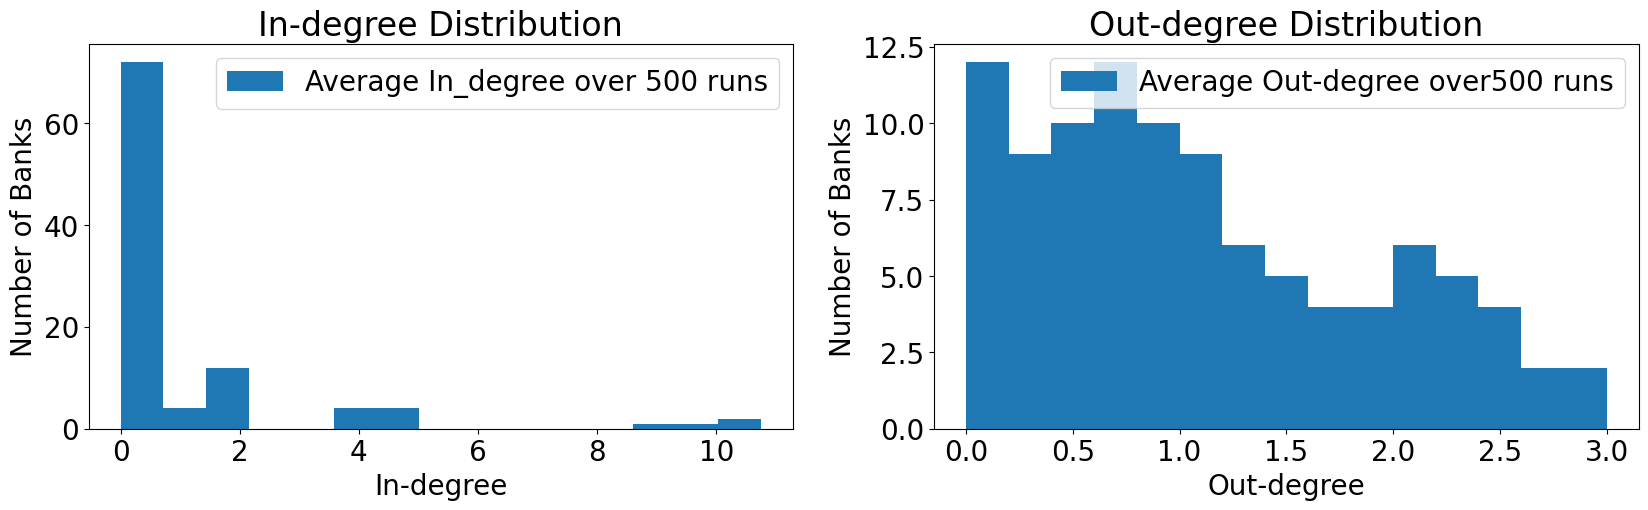

In [79]:
def plot_degree_distribution(t):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 5)
    ax1.set_title("In-degree Distribution")
    ax1.hist(IndegreeCollection[t], label="Average In_degree over " + str(simulationSteps) + " runs", bins=15)
    ax1.set_xlabel("In-degree")
    ax1.set_ylabel("Number of Banks")
    ax1.legend()

    ax2.set_title("Out-degree Distribution")
    ax2.hist(OutdegreeCollection[t], label="Average Out-degree over" + str(simulationSteps) + " runs", bins=15)
    ax2.set_xlabel("Out-degree")
    ax2.set_ylabel("Number of Banks")
    ax2.legend()
    plt.show()

plot_degree_distribution(simulationSteps-1)

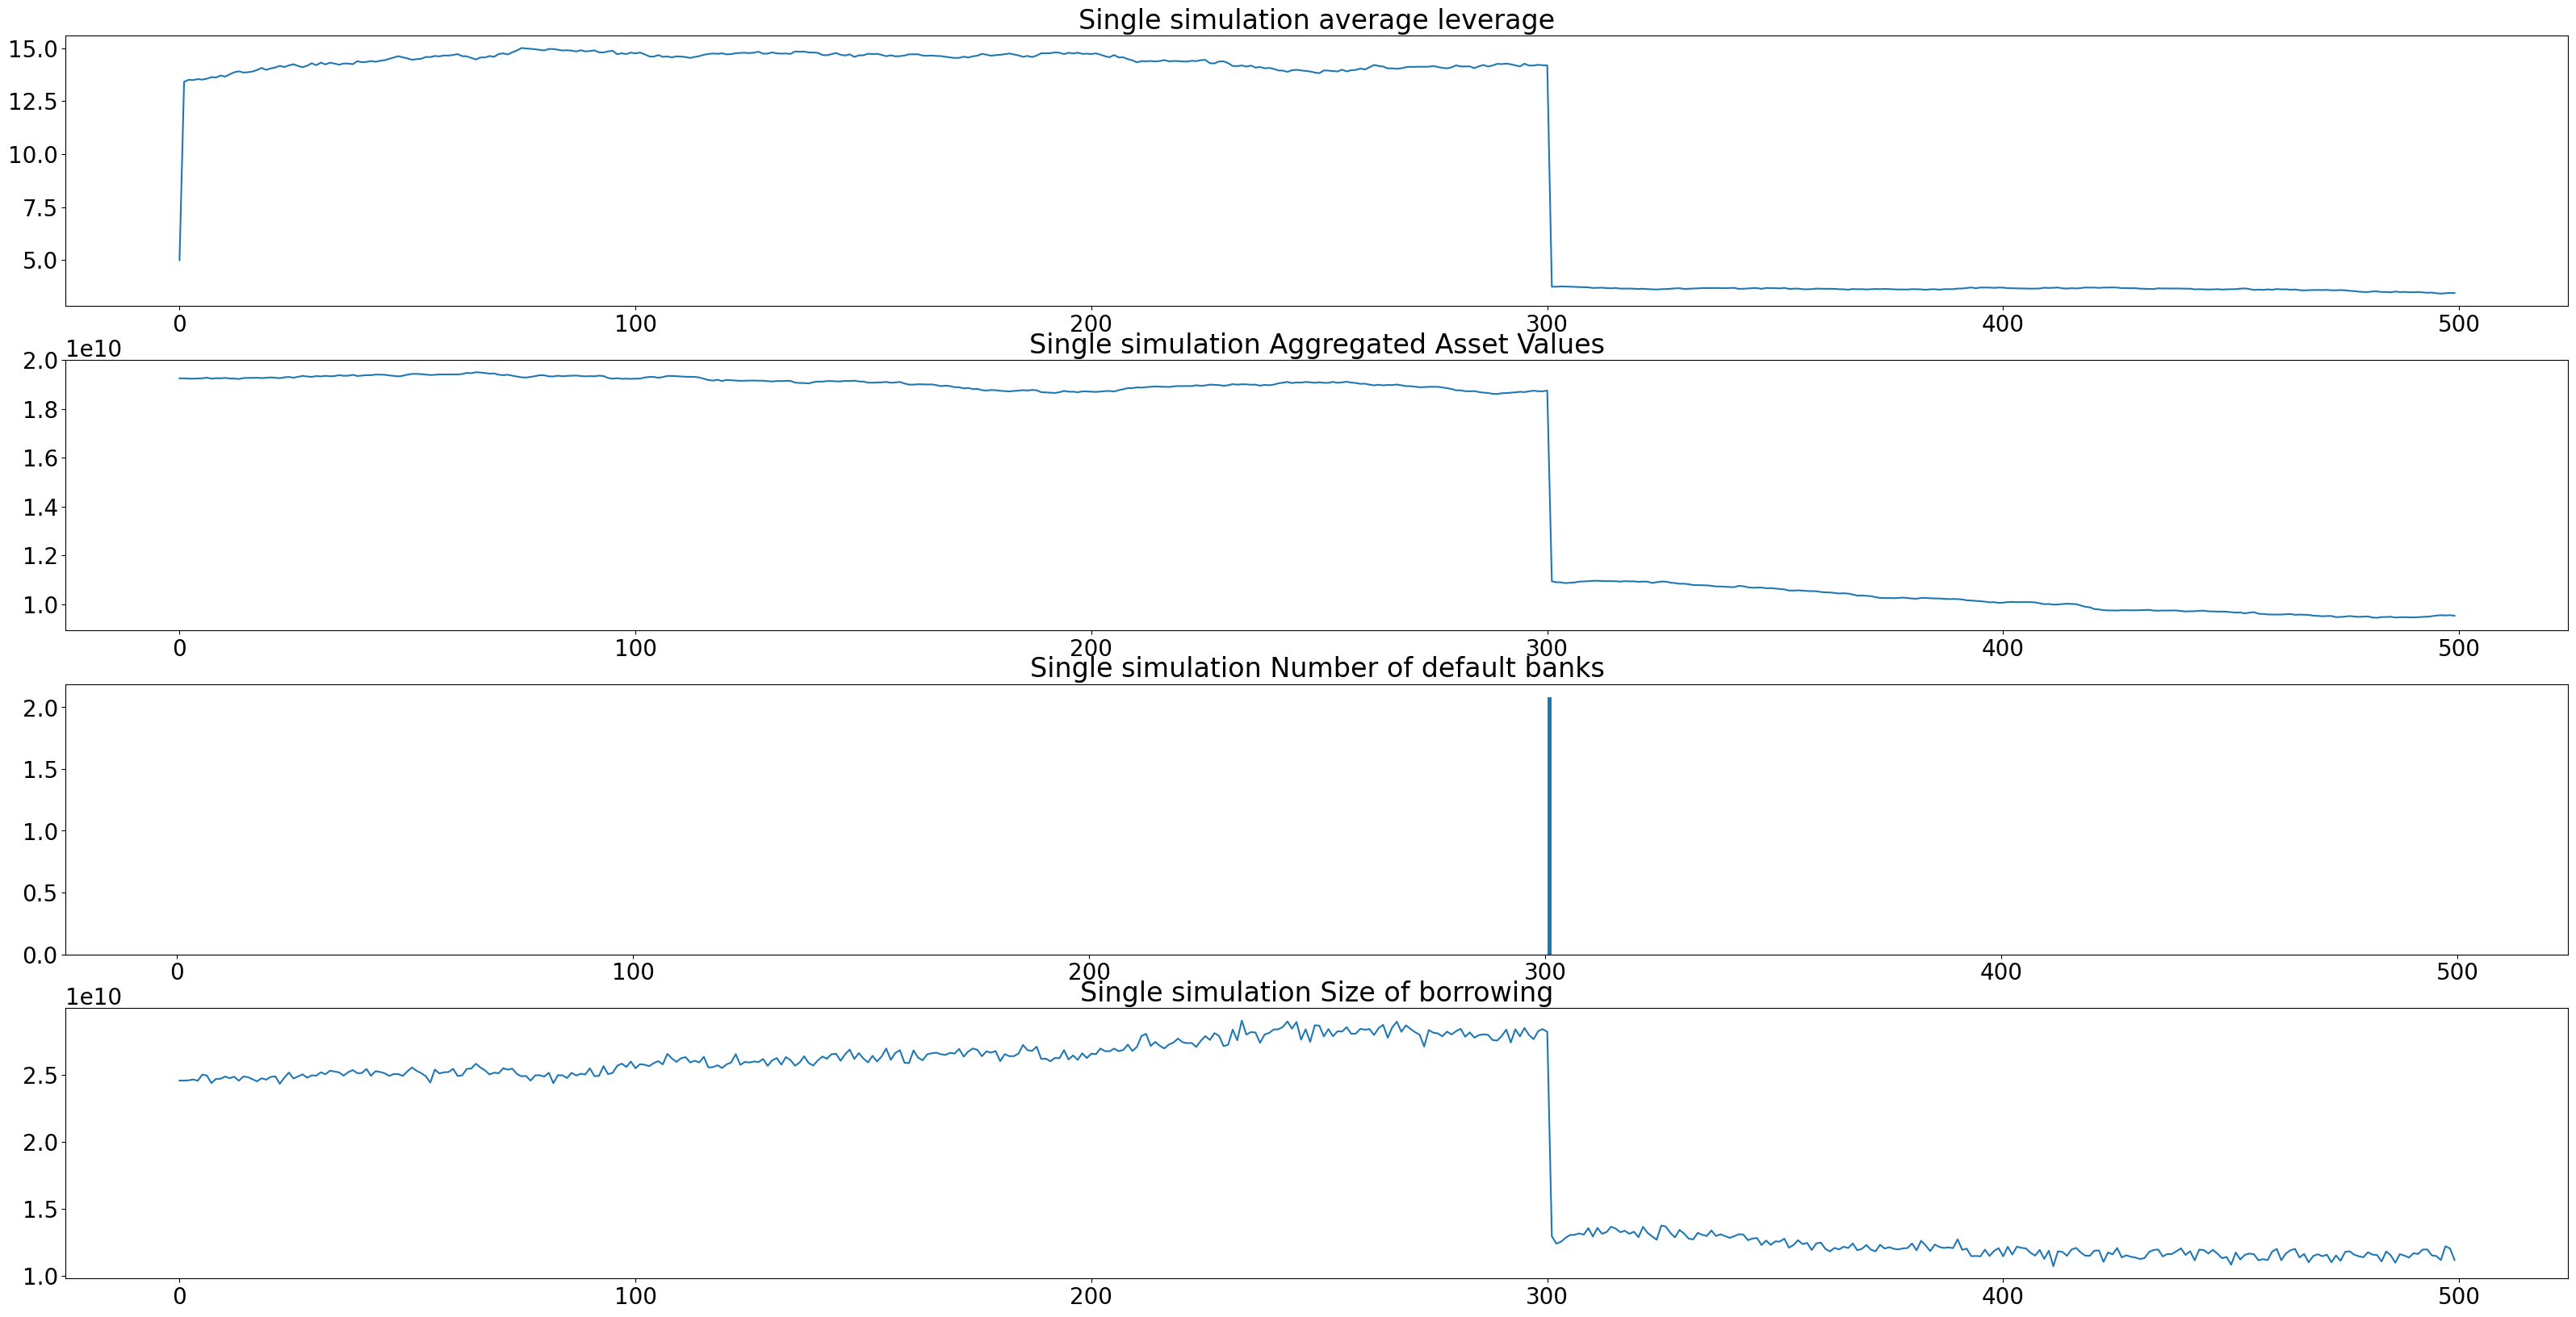

In [80]:
simulationMonitor(agentData, modelData, simulationSteps)

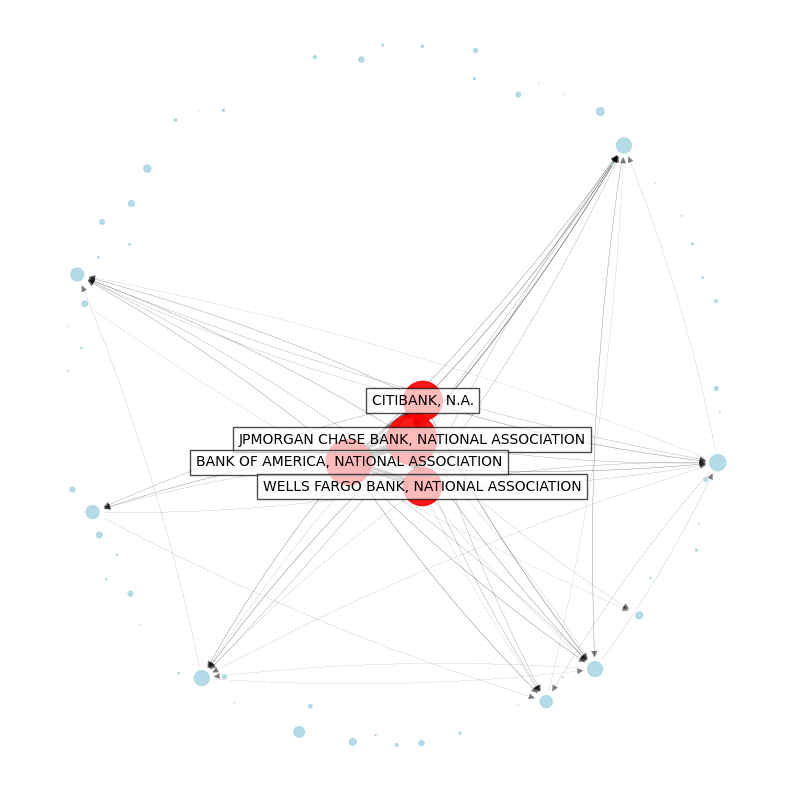

In [81]:
step = 450
model = bankingSystem(params)
netWorkGraph2(modelData["Liability Matrix"][step]/modelData["Liability Matrix"][step].sum()*10, model, printLabel=True)

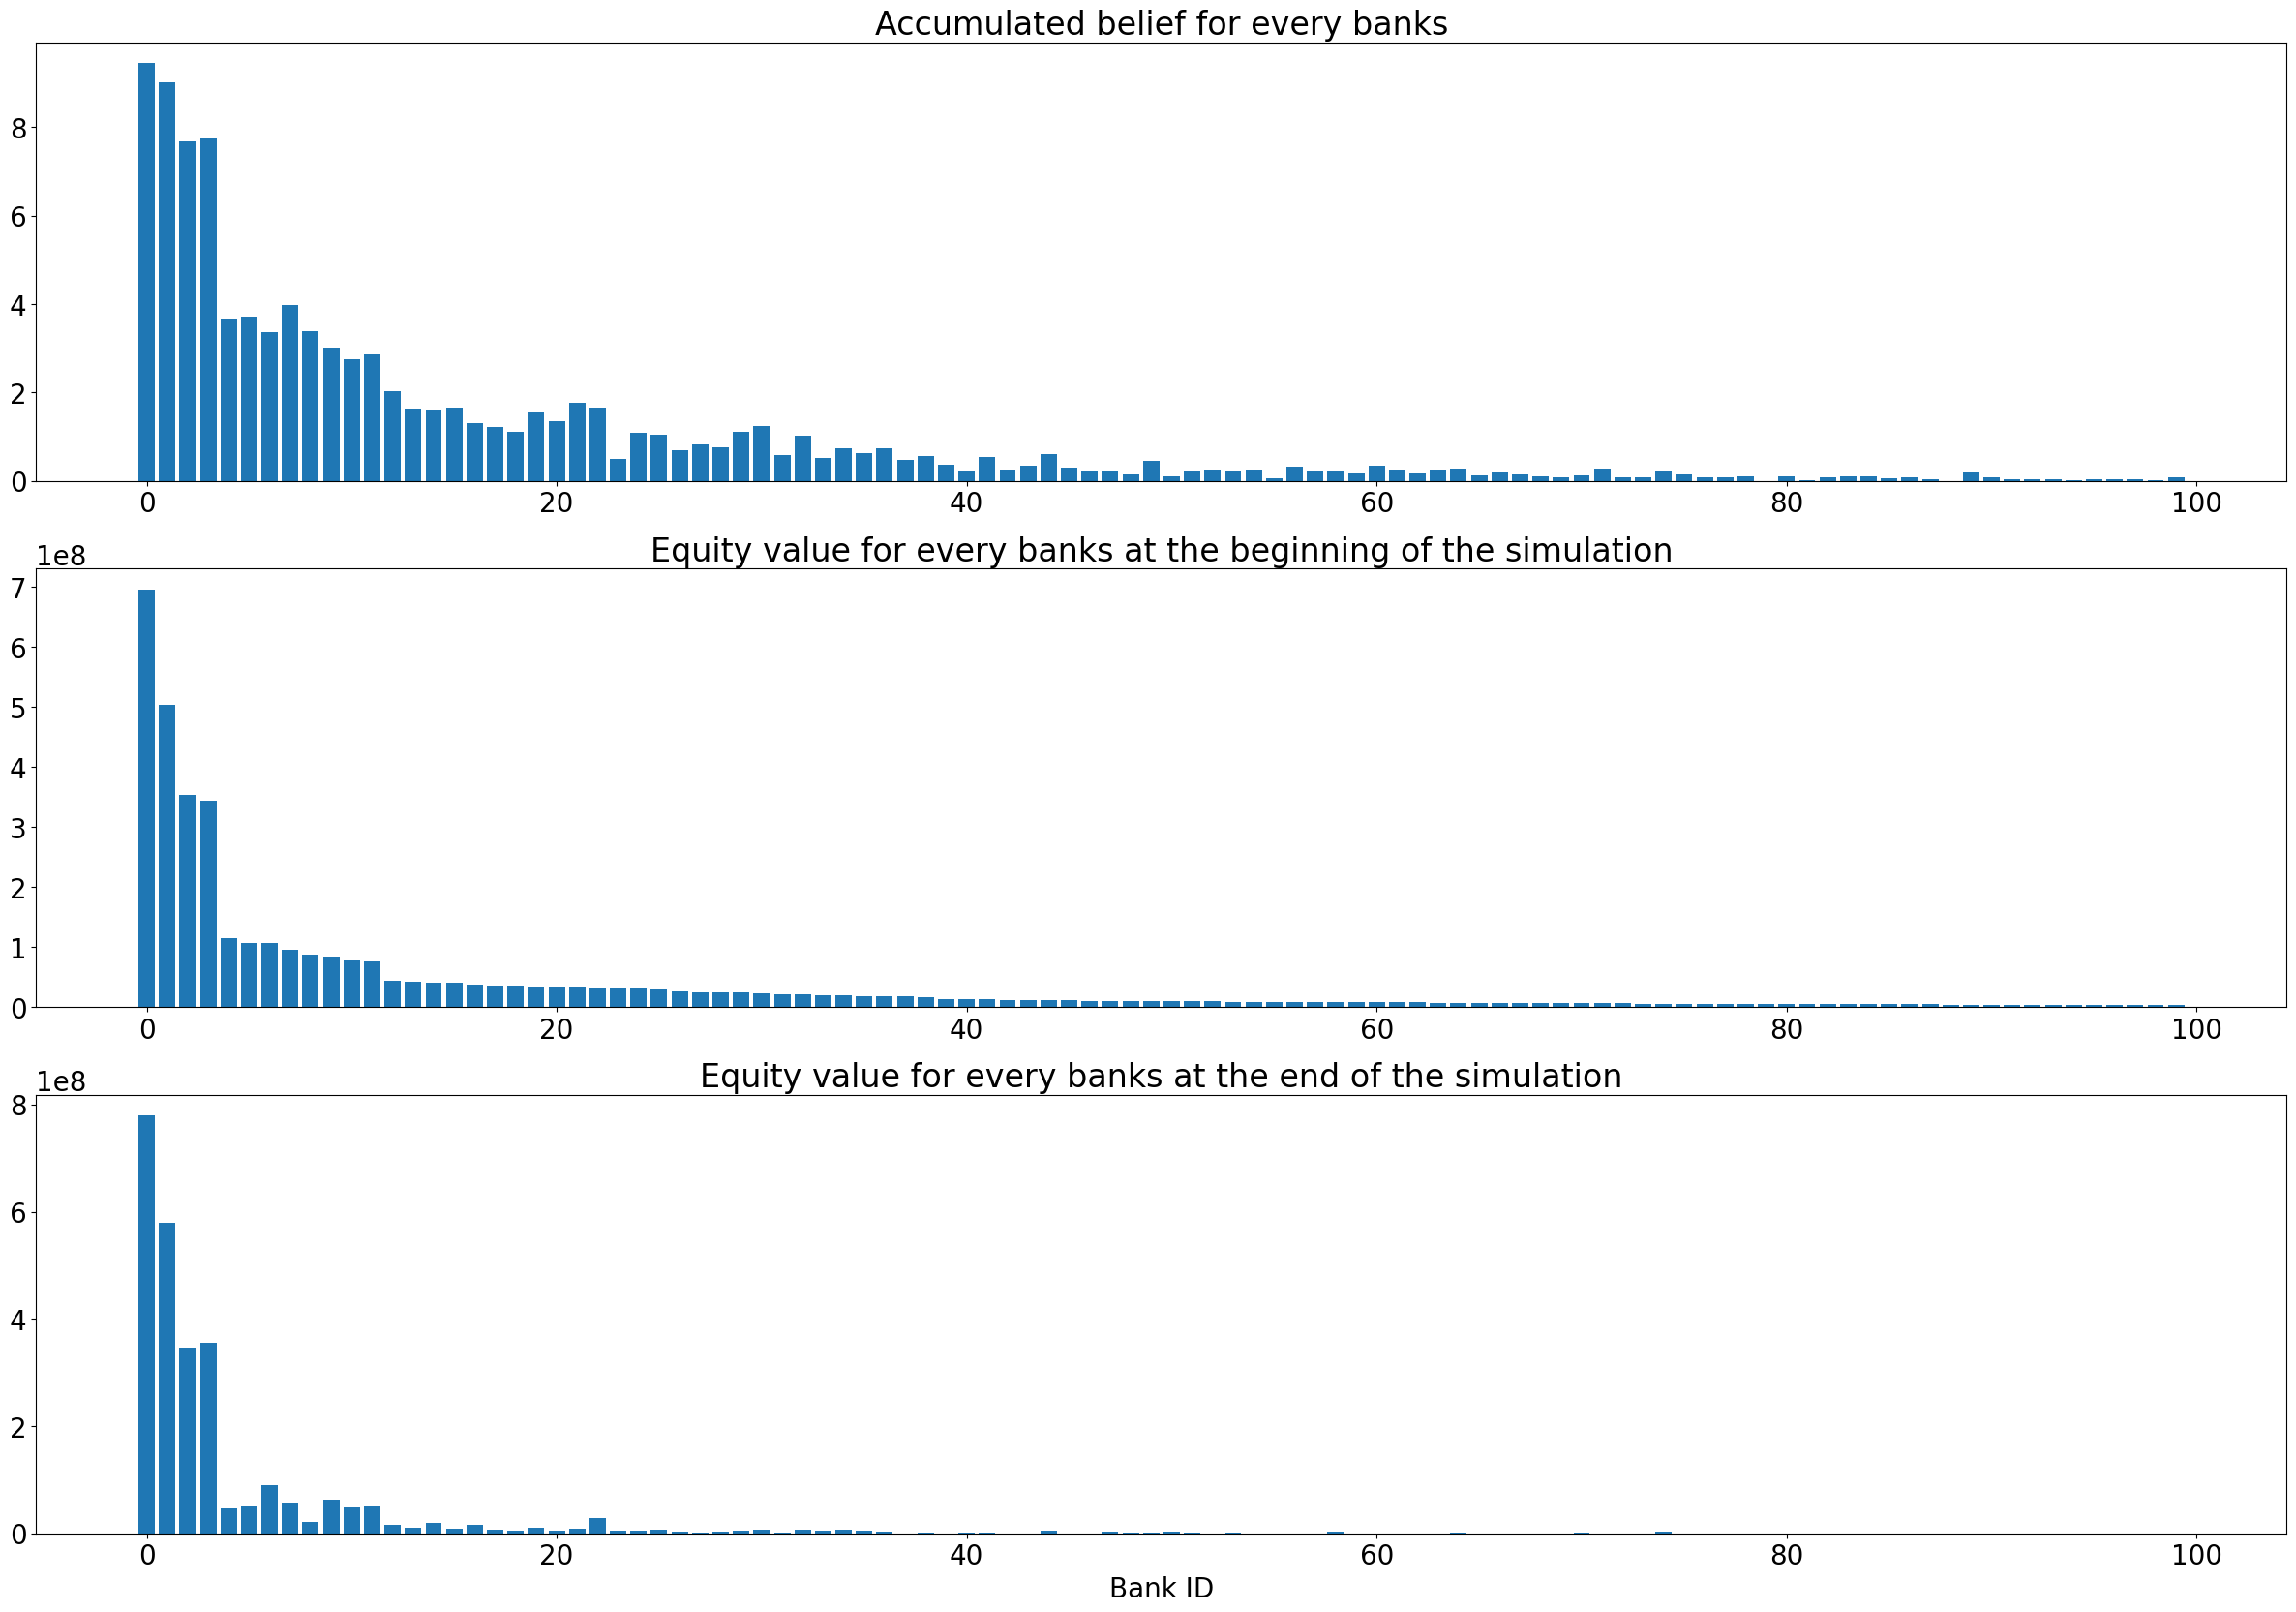

In [82]:
# bar chart of portfolio value
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(30, 20)
ax1.bar(range(100), modelData["Trust Matrix"][simulationSteps].sum(axis = 0))
ax1.set_title("Accumulated belief for every banks")
ax2.bar(range(100), agentData.xs(0, level="Step")["Equity"])
ax2.set_title("Equity value for every banks at the beginning of the simulation")
ax3.bar(range(100), agentData.xs(500, level="Step")["Equity"])
ax3.set_title("Equity value for every banks at the end of the simulation")
ax3.set_xlabel("Bank ID")
plt.show()